# Importation des librairies

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import os.path

from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored , concordance_index_ipcw
from sklearn.impute import SimpleImputer
from sksurv.util import Surv
from lifelines.utils import concordance_index



# Preprocessing

In [2]:
clinical_test=pd.read_csv('data/clinical_test.csv')
clinical_train=pd.read_csv('data/clinical_train.csv')

molecular_test=pd.read_csv('data/molecular_test.csv')
molecular_train=pd.read_csv('data/molecular_train.csv')


In [3]:
target_df=pd.read_csv('data/target_train.csv')

# Drop rows where 'OS_YEARS' is NaN if conversion caused any issues
target_df.dropna(subset=['OS_YEARS', 'OS_STATUS'], inplace=True)


# Contarget_dfvert 'OS_YEARS' to numeric if it isn’t already
target_df['OS_YEARS'] = pd.to_numeric(target_df['OS_YEARS'], errors='coerce')

# Ensure 'OS_STATUS' is boolean
target_df['OS_STATUS'] = target_df['OS_STATUS'].astype(bool)

In [4]:
from sklearn.impute import KNNImputer

def precise_missing_values(df):
    # Imputation KNN pour les variables numériques
    num_cols = df.select_dtypes(include=['float64', 'int64']).columns
    imputer = KNNImputer(n_neighbors=5)
    df[num_cols] = imputer.fit_transform(df[num_cols])

    # Pour les variables catégorielles, on remplace par 'Missing'
    cat_cols = df.select_dtypes(include=['object']).columns
    for col in cat_cols:
        df[col] = df[col].fillna('Missing')
    return df

clinical_train = precise_missing_values(clinical_train)
clinical_test = precise_missing_values(clinical_test)
molecular_train = precise_missing_values(molecular_train)
molecular_test = precise_missing_values(molecular_test)

In [5]:
import pandas as pd
import numpy as np

def aggregate_leukemia_data_improved(df, clinical_df=None):
    """
    Agrégation avancée des données de mutations par patient avec intégration
    des facteurs pronostiques ELN 2022 et des recommandations cliniques.
    (Version sans intégration des données cliniques)
    """
    # === DÉFINITIONS DES GÈNES SELON ELN 2022 ===
    adverse_genes = {
        'TP53', 'ASXL1', 'RUNX1', 'EZH2', 'SF3B1', 'SRSF2', 'U2AF1', 
        'ZRSR2', 'STAG2', 'BCOR', 'SETBP1'
    }
    dna_methylation_genes = {'DNMT3A', 'TET2', 'IDH1', 'IDH2'}
    favorable_genes = {'NPM1', 'CEBPA'}
    all_genes = [
        'GNB1', 'CSF3R', 'MPL', 'NRAS', 'HAX1', 'RIT1', 'SMC3', 'WT1', 'ATM', 'CBL',
        'ETV6', 'ETNK1', 'KRAS', 'ARID2', 'NFE2', 'SH2B3', 'PTPN11', 'FLT3', 'BRCA2',
        'PDS5B', 'IDH2', 'BLM', 'CREBBP', 'CTCF', 'PRPF8', 'TP53', 'NF1', 'SUZ12',
        'STAT5B', 'STAT3', 'PPM1D', 'SRSF2', 'SETBP1', 'BCL2', 'EPOR', 'CALR', 'CEBPA',
        'U2AF2', 'DNMT3A', 'ASXL2', 'SF3B1', 'IDH1', 'ASXL1', 'GNAS', 'RUNX1', 'U2AF1',
        'CHEK2', 'MYD88', 'GATA2', 'KIT', 'TET2', 'TERT', 'IRF1', 'CSNK1A1', 'NPM1',
        'NSD1', 'DDX41', 'JARID2', 'CCND3', 'VEGFA', 'IKZF1', 'EGFR', 'SBDS', 'CUX1',
        'BRAF', 'EZH2', 'RAD21', 'JAK2', 'CDKN2A', 'FANCG', 'NOTCH1', 'PIGA', 'ZRSR2',
        'BCOR', 'USP9X', 'KDM6A', 'SMC1A', 'MED12', 'STAG2', 'BCORL1', 'PHF6', 'BRCC3',
        'MLL'
    ]
    gene_weights = {
        'TP53': 5.0,
        'ASXL1': 2.0, 'RUNX1': 2.0, 'EZH2': 2.0,
        'SF3B1': 1.8, 'SRSF2': 1.8, 'U2AF1': 1.8, 'ZRSR2': 1.8,
        'STAG2': 1.5, 'BCOR': 1.5, 'SETBP1': 1.5,
        'DNMT3A': 1.5, 'TET2': 1.5, 'IDH1': 1.8, 'IDH2': 1.8,
        'FLT3': 2.0,
        'NPM1': -2.5,
        'CEBPA': -3.0,
        'KIT': 1.2, 'NRAS': 0.8, 'KRAS': 0.8, 'PTPN11': 0.8
    }
    bad_effects = ['nonsense', 'frameshift', 'splice_site', 'stop_gained']
    # === AGRÉGATION BASIQUE ===
    result = df.groupby('ID').agg({
        'GENE': ['count', 'nunique'],
        'CHR': 'nunique',
        'VAF': ['mean', 'max', 'median', 'min', 'var'],
        'DEPTH': ['mean', 'median', 'min', 'max', 'var']
    }).reset_index()
    result.columns = [
        'ID', 'nb_mutations', 'nb_genes', 'nb_chromosomes',
        'vaf_mean', 'vaf_max', 'vaf_median', 'vaf_min', 'vaf_var',
        'depth_mean', 'depth_median', 'depth_min', 'depth_max', 'depth_var'
    ]
    # === MATRICE BINAIRE GÈNE x PATIENT ===
    has_gene = (
        df.pivot_table(index='ID', columns='GENE', values='CHR', aggfunc='size', fill_value=0)
        .reindex(columns=all_genes, fill_value=0)
        .astype(int)
    )
    has_gene.columns = [f'has_{g}' for g in has_gene.columns]
    has_gene.reset_index(inplace=True)
    result = result.merge(has_gene, on='ID', how='left')
    # === NOUVEAUX INDICATEURS GÉNÉTIQUES ===
    adverse_cols = [f'has_{g}' for g in adverse_genes if f'has_{g}' in result.columns]
    result['has_adverse_gene'] = result[adverse_cols].sum(axis=1).clip(upper=1)
    result['nb_adverse_genes'] = result[adverse_cols].sum(axis=1)
    methylation_cols = [f'has_{g}' for g in dna_methylation_genes if f'has_{g}' in result.columns]
    result['has_methylation_gene'] = result[methylation_cols].sum(axis=1).clip(upper=1)
    result['nb_methylation_genes'] = result[methylation_cols].sum(axis=1)
    result['has_NPM1_favorable'] = result.get('has_NPM1', 0)
    result['has_CEBPA_favorable'] = result.get('has_CEBPA', 0)
    result['high_mutation_burden'] = (result['nb_mutations'] > 3).astype(int)
    result['mutation_burden_score'] = np.where(
        result['nb_mutations'] > 3, 
        (result['nb_mutations'] - 3) * 0.5, 
        0
    )
    result['nb_bad_effects'] = df.groupby('ID')['EFFECT'].apply(lambda x: x.isin(bad_effects).sum()).values
    result['nb_high_vaf'] = df.groupby('ID')['VAF'].apply(lambda x: (x > 0.4).sum()).values
    result['nb_very_high_vaf'] = df.groupby('ID')['VAF'].apply(lambda x: (x > 0.6).sum()).values
    # === CALCUL DU SCORE DE RISQUE AMÉLIORÉ (SANS CLINIQUE) ===
    has_cols = [f'has_{g}' for g in gene_weights if f'has_{g}' in result.columns]
    weights_series = pd.Series([gene_weights[g] for g in gene_weights if f'has_{g}' in result.columns], 
                              index=has_cols)
    gene_score = result[has_cols].dot(weights_series)
    methylation_penalty = np.where(result['nb_methylation_genes'] >= 2, 
                                  result['nb_methylation_genes'] * 0.8, 0)
    npm1_modulation = 0
    if 'has_NPM1' in result.columns and 'has_FLT3' in result.columns:
        npm1_modulation = np.where(
            (result['has_NPM1'] == 1) & (result['has_FLT3'] == 1),
            1.5,
            0
        )
    result['risk_score_genetic'] = (
        gene_score +
        methylation_penalty +
        npm1_modulation +
        result['mutation_burden_score'] +
        0.3 * result['nb_high_vaf'] +
        0.5 * result['nb_very_high_vaf']
    )
    result['risk_score_raw'] = result['risk_score_genetic']
    def enhanced_logistic(score, intercept=3.0, scale=2.5, floor=0.05, ceiling=0.95):
        z = (score - intercept) / scale
        prob = 1.0 / (1.0 + np.exp(-z))
        return np.clip(prob, floor, ceiling)
    result['risk_score_prob'] = result['risk_score_raw'].apply(enhanced_logistic)
    def classify_eln_risk(row):
        if ((row.get('has_NPM1', 0) == 1 and row.get('has_FLT3', 0) == 0) or
            row.get('has_CEBPA', 0) == 1):
            if row['has_adverse_gene'] == 0:
                return 'Favorable'
        if (row['has_adverse_gene'] == 1 or 
            row.get('has_TP53', 0) == 1 or
            row['nb_adverse_genes'] >= 2):
            return 'Adverse'
        return 'Intermediate'
    result['eln_risk_category'] = result.apply(classify_eln_risk, axis=1)
    result['genetic_complexity'] = (
        result['nb_genes'] + 
        result['nb_adverse_genes'] * 2 + 
        result['nb_methylation_genes']
    )
    result['vaf_heterogeneity'] = result['vaf_var'].fillna(0)
    return result

def aggregation(molecular_train, molecular_test, clinical_train=None, clinical_test=None):
    molecular_train_agg = aggregate_leukemia_data_improved(molecular_train, clinical_train)
    molecular_test_agg = aggregate_leukemia_data_improved(molecular_test, clinical_test)
    return molecular_train_agg, molecular_test_agg

# Exemple d'utilisation :
molecular_train_agg, molecular_test_agg = aggregation(molecular_train, molecular_test, clinical_train, clinical_test)


In [6]:
import re
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

def extract_cytogenetic_features(data):
    """Extrait les anomalies chromosomiques fréquentes"""
    abnormalities = {
        "monosomy_7": r"[-]7|\bdel\(7",
        "monosomy_5": r"[-]5|\bdel\(5",
        "del_20q": r"del\(20\)\(q",
        "inv_16": r"inv\(16\)",
        "t_8_21": r"t\(8;21\)",
        "t_15_17": r"t\(15;17\)",
        "t_3_3": r"t\(3;3",
        "del_3_q26": r"del\(3\)\(q26",
        "t_3_9": r"t\(3;9\)",
        "trisomy_8": r"\+8"
    }

    for name, regex in abnormalities.items():
        data[name] = data["CYTOGENETICS"].str.contains(regex, case=False, na=False).astype(int)

    # Complex karyotype = 3 anomalies ou plus
    def is_complex(k):
        if pd.isna(k):
            return 0
        # Compter les délétions, translocations, inversions, etc.
        anomalies = re.findall(r"del\(|t\(|inv\(|ins\(|\+\d+|-\d+", str(k))
        return int(len(anomalies) >= 3)
    
    data["complex_karyotype"] = data["CYTOGENETICS"].apply(is_complex)
    return data

def assign_eln_risk(row):
    """Classification ELN 2022 des risques pronostiques"""
    # Risque favorable
    if row["t_8_21"] == 1 or row["inv_16"] == 1 or row["t_15_17"] == 1:
        return "favorable"
    # Risque défavorable
    elif (row["monosomy_7"] == 1 or row["monosomy_5"] == 1 or 
          row["complex_karyotype"] == 1 or row["t_3_3"] == 1 or row["del_3_q26"] == 1):
        return "adverse"
    # Risque intermédiaire
    else:
        return "intermediate"

def extract_structural_numerical_anomalies(data):
    """Extrait les anomalies structurelles vs numériques"""
    def count_structural(k):
        if pd.isna(k):
            return 0
        # Anomalies structurelles : délétions, translocations, inversions, insertions
        structural = re.findall(r"del\(|t\(|inv\(|ins\(", str(k))
        return len(structural)
    
    def count_numerical(k):
        if pd.isna(k):
            return 0
        # Anomalies numériques : gains (+) et pertes (-) de chromosomes entiers
        numerical = re.findall(r"\+\d+|-\d+", str(k))
        return len(numerical)
    
    data["structural_anomalies_count"] = data["CYTOGENETICS"].apply(count_structural)
    data["numerical_anomalies_count"] = data["CYTOGENETICS"].apply(count_numerical)
    return data

def extract_chromosome_details(data):
    """Extrait les détails des chromosomes impliqués"""
    def get_involved_chromosomes(k):
        if pd.isna(k):
            return []
        # Extraire tous les numéros de chromosomes mentionnés
        chromosomes = re.findall(r"(?:del\(|t\(|inv\(|ins\()(\d+)", str(k))
        chromosomes += re.findall(r"[+-](\d+)", str(k))
        return list(set(chromosomes))  # Supprimer les doublons
    
    data["involved_chromosomes"] = data["CYTOGENETICS"].apply(get_involved_chromosomes)
    data["num_involved_chromosomes"] = data["involved_chromosomes"].apply(len)
    
    # Créer des colonnes binaires pour les chromosomes les plus fréquemment impliqués
    common_chromosomes = ['3', '5', '7', '8', '9', '11', '15', '16', '17', '20', '21', '22']
    for chr_num in common_chromosomes:
        data[f"chr_{chr_num}_involved"] = data["involved_chromosomes"].apply(
            lambda x: 1 if chr_num in x else 0
        )
    
    return data

def create_cytogenetic_embeddings(data, max_features=100):
    """Crée des embeddings TF-IDF sur les chaînes CYTOGENETICS"""
    # Préparation des données pour TF-IDF
    cyto_texts = data["CYTOGENETICS"].fillna("normal").astype(str)
    
    # Tokenization spéciale pour les données cytogénétiques
    def cyto_tokenizer(text):
        # Extraire les éléments cytogénétiques comme tokens
        tokens = []
        tokens.extend(re.findall(r"del\(\d+\)\([pq]\d*\)", text))  # délétions
        tokens.extend(re.findall(r"t\(\d+;\d+\)", text))  # translocations
        tokens.extend(re.findall(r"inv\(\d+\)", text))  # inversions
        tokens.extend(re.findall(r"[+-]\d+", text))  # gains/pertes
        tokens.extend(re.findall(r"\d+,XX|\d+,XY", text))  # formules de base
        return tokens
    
    # Créer le vectoriseur TF-IDF
    vectorizer = TfidfVectorizer(
        tokenizer=cyto_tokenizer,
        max_features=max_features,
        lowercase=False
    )
    
    # Ajuster et transformer
    tfidf_matrix = vectorizer.fit_transform(cyto_texts)
    
    # Convertir en DataFrame
    feature_names = [f"tfidf_{i}" for i in range(tfidf_matrix.shape[1])]
    tfidf_df = pd.DataFrame(
        tfidf_matrix.toarray(), 
        columns=feature_names, 
        index=data.index
    )
    
    # Joindre au DataFrame principal
    data = pd.concat([data, tfidf_df], axis=1)
    return data

def preprocess(data, include_embeddings=True):
    """
    Fonction de preprocessing complète pour les données cytogénétiques
    
    Parameters:
    -----------
    data : pd.DataFrame
        DataFrame contenant la colonne CYTOGENETICS
    include_embeddings : bool
        Si True, inclut les embeddings TF-IDF (peut être coûteux en mémoire)
    
    Returns:
    --------
    pd.DataFrame
        DataFrame enrichi avec toutes les features cytogénétiques
    """
    
    # 1. Normalisation de la casse des chromosomes (tout en majuscule)
    data["CYTOGENETICS"] = data["CYTOGENETICS"].str.upper()
    
    # 2. Indicateur si le caryotype est anormal (inversé par rapport à l'original)
    data["is_abnormal"] = (~data["CYTOGENETICS"].str.contains("46,XX|46,XY", case=False, na=False)).astype(int)
    # Garder aussi l'indicateur normal pour compatibilité
    data["is_normal"] = 1 - data["is_abnormal"]
    
    # 3. Extraction du nombre total de chromosomes
    data["total_chromosomes"] = data["CYTOGENETICS"].str.extract(r"^(\d+)", expand=False).astype(float)
    # Remplir avec 46 si non détecté et caryotype normal
    data.loc[~data["total_chromosomes"].notna(), "total_chromosomes"] = 46
    
    # 4. Extraction du sexe brut (ex: XY, XX)
    data["sex_raw"] = data["CYTOGENETICS"].str.extract(r"\b(XX|XY|XYY|XXY|XXX|YY)\b", expand=False)
    
    # 5. Normalisation du sexe : catégorisation des cas atypiques
    data["sex"] = data["sex_raw"].apply(lambda s: s if s in ["XX", "XY"] else "Other")
    
    # 6. Extraction des anomalies chromosomiques fréquentes
    data = extract_cytogenetic_features(data)
    
    # 7. Classification ELN des risques
    data["eln_risk"] = data.apply(assign_eln_risk, axis=1)
    
    # 8. Encodage ordinal du risque ELN
    eln_risk_mapping = {"favorable": 0, "intermediate": 1, "adverse": 2}
    data["eln_risk_ordinal"] = data["eln_risk"].map(eln_risk_mapping)
    
    # 9. Nombre de clones
    data["number_of_clones"] = data["CYTOGENETICS"].str.findall(r"\[(\d+)\]").apply(
        lambda x: sum(map(int, x)) if x else 0
    )
    
    # 10. Anomalies structurelles vs numériques
    data = extract_structural_numerical_anomalies(data)
    
    # 11. Détails des chromosomes impliqués
    data = extract_chromosome_details(data)
    
    # 12. Ratio anomalies structurelles/numériques
    data["structural_numerical_ratio"] = data["structural_anomalies_count"] / (
        data["numerical_anomalies_count"] + 1
    )  # +1 pour éviter division par zéro
    
    # 13. Score de complexité globale
    data["complexity_score"] = (
        data["structural_anomalies_count"] + 
        data["numerical_anomalies_count"] + 
        data["num_involved_chromosomes"]
    )
    
    # 14. Embeddings TF-IDF (optionnel)
    if include_embeddings:
        data = create_cytogenetic_embeddings(data)
    
    # 15. Nettoyage des colonnes intermédiaires
    columns_to_drop = ["sex_raw", "involved_chromosomes"]
    data.drop(columns=[col for col in columns_to_drop if col in data.columns], inplace=True)
    
    return data

# Exemple d'utilisation avec gestion des erreurs
def preprocess_safe(data, include_embeddings=True):
    """Version sécurisée du preprocessing avec gestion des erreurs"""
    try:
        return preprocess(data.copy(), include_embeddings=include_embeddings)
    except Exception as e:
        print(f"Erreur lors du preprocessing: {e}")
        print("Retour de la version de base...")
        return preprocess_basic(data.copy())

def preprocess_basic(data):
    """Version de base du preprocessing en cas d'erreur"""
    data["CYTOGENETICS"] = data["CYTOGENETICS"].str.upper()
    data["is_abnormal"] = (~data["CYTOGENETICS"].str.contains("46,XX|46,XY", case=False, na=False)).astype(int)
    data["total_chromosomes"] = data["CYTOGENETICS"].str.extract(r"^(\d+)", expand=False).astype(float)
    data.loc[~data["total_chromosomes"].notna(), "total_chromosomes"] = 46
    return data

# Appliquer la fonction aux datasets
clinical_test = preprocess(clinical_test)
clinical_train = preprocess(clinical_train)


c:\Users\arthr\Desktop\ENSAE 1A\QRT-Challenge-2025\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\arthr\Desktop\ENSAE 1A\QRT-Challenge-2025\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [7]:
clinical_test = clinical_test.drop('CYTOGENETICS', axis=1)
clinical_train = clinical_train.drop('CYTOGENETICS', axis=1)

In [8]:
df_train = clinical_train.merge(molecular_train_agg, on='ID', how='left').fillna(0)
df_test = clinical_test.merge(molecular_test_agg, on='ID', how='left').fillna(0)

In [9]:
df_train['mutation_burden'] = df_train['nb_mutations'] * df_train['vaf_mean']
df_test['mutation_burden'] = df_test['nb_mutations'] * df_test['vaf_mean']


for col in ['HB', 'PLT', 'BM_BLAST']:
    lower = df_train[col].quantile(0.01)
    upper = df_train[col].quantile(0.99)
    df_train[col] = df_train[col].clip(lower, upper)
    df_test[col] = df_test[col].clip(lower, upper)


In [10]:
from sklearn.preprocessing import RobustScaler

# Colonnes numériques hors cibles, présentes dans le train
features = [col for col in df_train.select_dtypes(include='number').columns if col not in ['OS_YEARS', 'OS_STATUS']]

# Ajoute les colonnes manquantes dans df_test
for col in features:
    if col not in df_test.columns:
        df_test[col] = 0

# Aligne l'ordre des colonnes
df_test = df_test.reindex(columns=df_train.columns)

scaler = RobustScaler()
df_train_scaled = df_train.copy()
df_test_scaled = df_test.copy()

df_train_scaled[features] = scaler.fit_transform(df_train[features])
df_test_scaled[features] = scaler.transform(df_test[features][features])

In [11]:
df_train_scaled = df_train_scaled.merge(target_df, on='ID', how='inner')

In [12]:
# prompt: supprime les variables ID et CENTER de df_train et de df_test
ID_test = df_test_scaled['ID']

df_train_scaled = df_train_scaled.drop(['ID', 'CENTER'], axis=1)
df_test_scaled = df_test_scaled.drop(['ID', 'CENTER'], axis=1)

In [19]:
df_train_scaled

,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,is_abnormal,is_normal,total_chromosomes,sex,...,nb_very_high_vaf,risk_score_genetic,risk_score_raw,risk_score_prob,eln_risk_category,genetic_complexity,vaf_heterogeneity,mutation_burden,OS_YEARS,OS_STATUS
0,1.567164,-0.393048,-0.692308,0.498039,-0.88,-0.056962,0.0,0.0,0.0,XY,...,0.0,1.854015,1.854015,0.496949,Adverse,1.666667,0.331931,1.305079,1.115068,True
1,-0.373134,0.836898,0.153846,-0.482353,0.72,-0.544304,0.0,0.0,0.0,XX,...,0.0,-0.145985,-0.145985,-0.174463,Adverse,0.166667,-0.260711,-0.001265,4.928767,False
2,1.716418,-0.152406,0.038462,-0.482353,1.76,-0.297468,0.0,0.0,0.0,XY,...,0.0,-0.175182,-0.175182,-0.211470,Adverse,0.166667,-0.261176,-0.634376,2.043836,False
3,-0.373134,-0.098930,-0.038462,-0.482353,-0.36,-0.322785,0.0,0.0,0.0,XY,...,0.0,1.620438,1.620438,0.496949,Adverse,2.500000,0.242486,1.338785,2.476712,True
4,0.373134,33.082888,2.961538,0.824837,0.52,0.424051,0.0,0.0,0.0,XX,...,0.0,-0.394161,-0.394161,-0.495984,Adverse,-0.500000,-0.262710,-0.314386,3.145205,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3168,-0.373134,-0.473262,-0.376923,-0.318954,0.16,-0.316456,0.0,0.0,1.0,XY,...,0.0,0.569343,0.569343,0.427624,Adverse,0.666667,1.072479,-0.130128,0.547945,False
3169,-0.298507,1.024064,0.253846,0.089542,0.60,-0.556962,1.0,-1.0,-2.0,XX,...,1.0,0.116788,0.116788,0.122341,Adverse,-0.333333,8.083546,0.031628,2.339726,False
3170,-0.522388,-0.660428,-0.557692,-0.171895,-0.16,-0.265823,0.0,0.0,0.0,XY,...,0.0,0.014599,0.014599,0.016227,Adverse,0.500000,0.467528,0.585487,1.997260,False
3171,0.223881,-0.775401,-0.626923,-0.466013,0.64,-0.164557,0.0,0.0,0.0,XX,...,0.0,0.744526,0.744526,0.487010,Adverse,0.166667,0.067959,-0.075005,0.095890,True


,count,mean,std,min,25%,50%,75%,max
BM_BLAST,3173.0,0.356317,0.956979,-0.522388,-0.313433,0.000000,0.671642,3.955224
WBC,3173.0,0.603056,2.690061,-1.088235,-0.393048,-0.018717,0.622995,40.141711
ANC,3173.0,0.490885,1.999328,-0.769231,-0.384615,0.000000,0.637308,41.392308
MONOCYTES,3173.0,0.841508,4.074267,-0.645752,-0.367974,-0.008497,0.627124,71.576471
HB,3173.0,0.026448,0.790551,-1.862400,-0.488000,-0.016000,0.520000,2.080000
...,...,...,...,...,...,...,...,...
risk_score_prob,3173.0,-0.125029,0.569999,-1.318649,-0.588105,0.000000,0.421497,0.496949
genetic_complexity,3173.0,0.093182,0.771067,-1.000000,-0.500000,0.000000,0.500000,4.166667
vaf_heterogeneity,3173.0,0.420808,1.007897,-0.262710,-0.261944,0.017078,0.740908,11.410495
mutation_burden,3173.0,0.179622,0.770290,-0.741008,-0.414603,0.014459,0.585577,3.491686


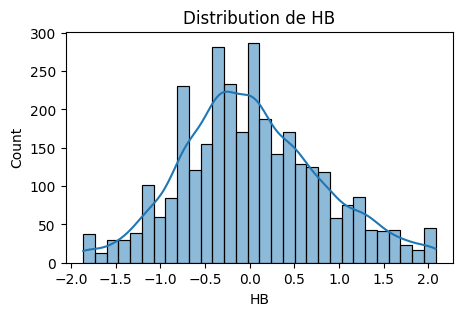

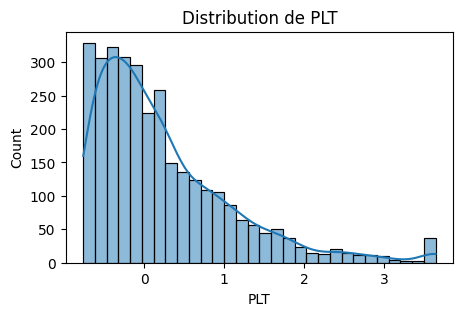

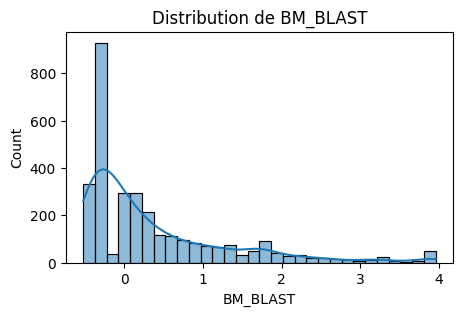

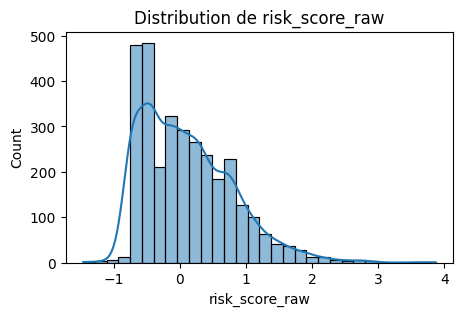

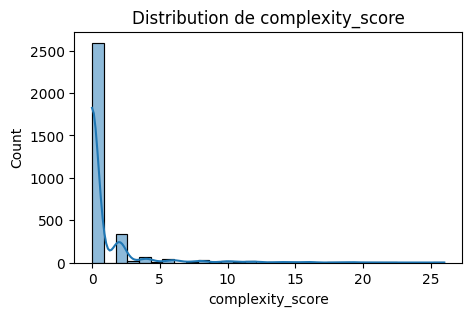

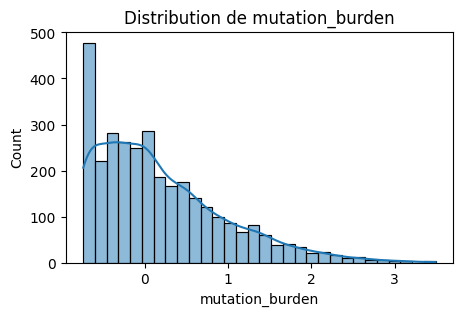

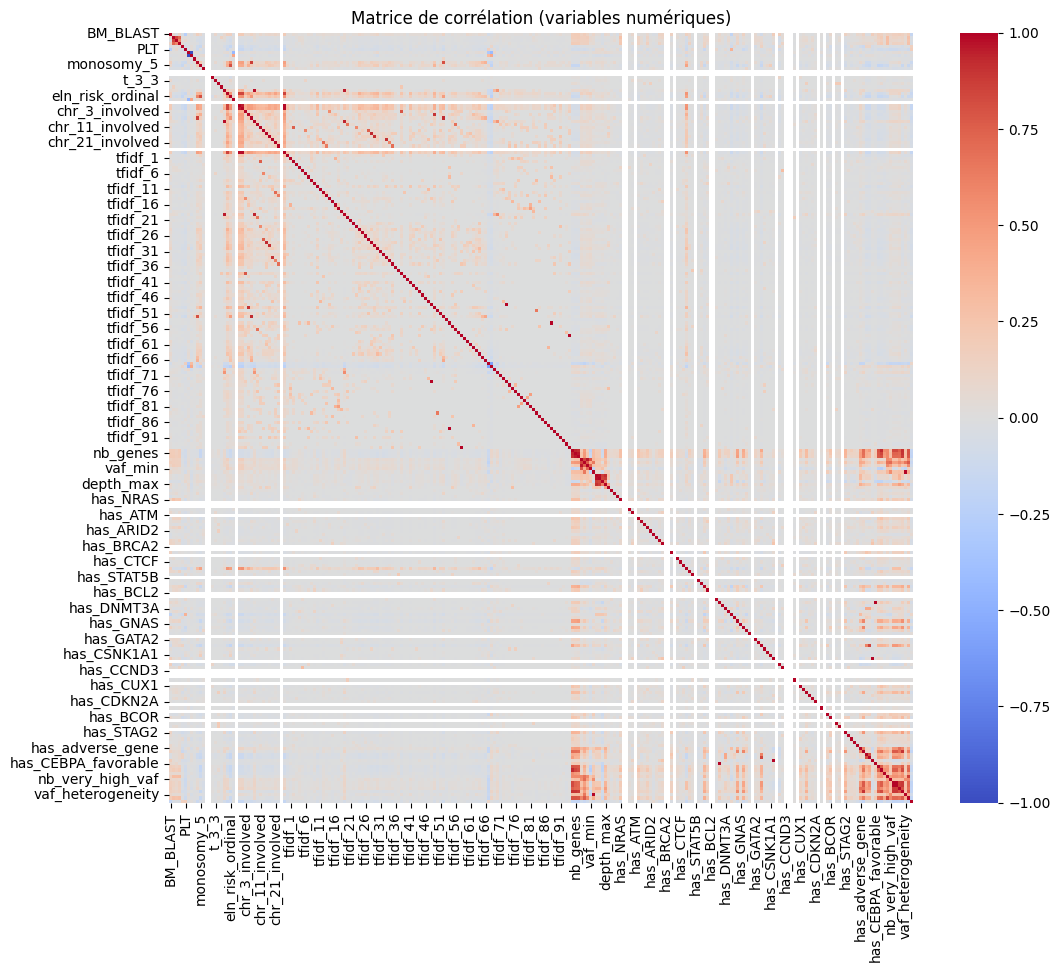

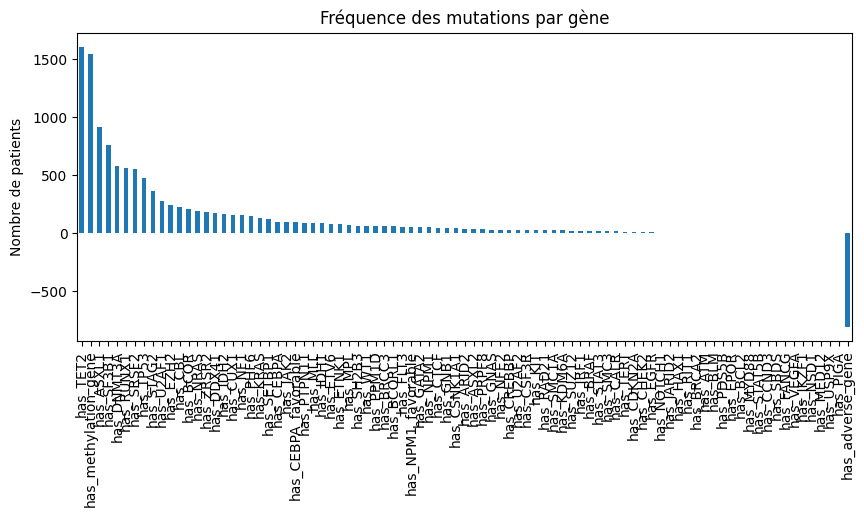

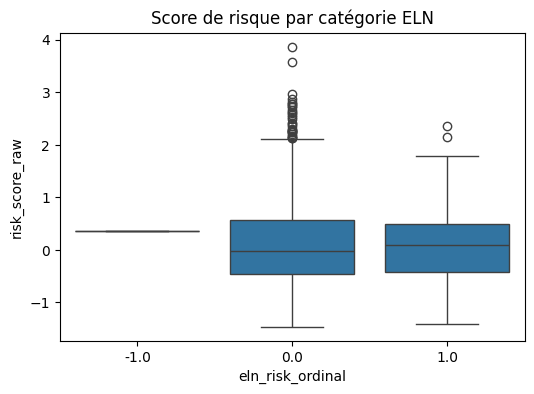

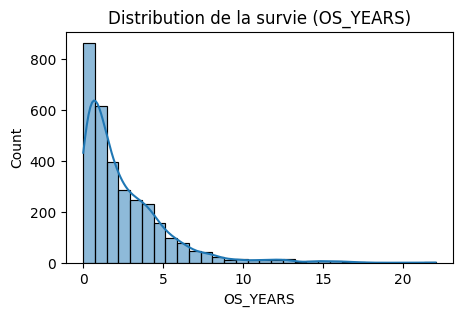

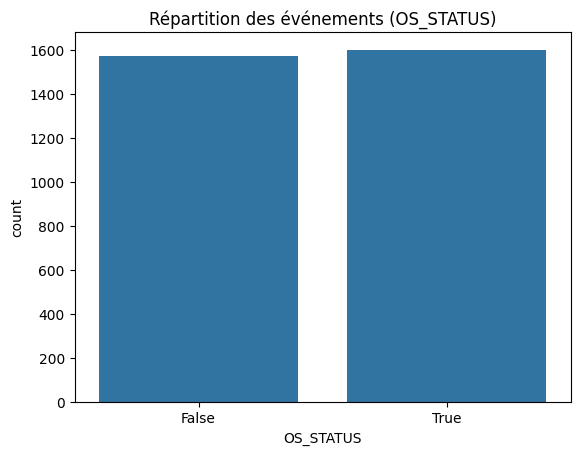

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Statistiques descriptives
display(df_train_scaled.describe().T)

# 2. Histogrammes des principales variables cliniques et scores
cols_to_plot = ['HB', 'PLT', 'BM_BLAST', 'risk_score_raw', 'complexity_score', 'mutation_burden']
for col in cols_to_plot:
    if col in df_train_scaled.columns:
        plt.figure(figsize=(5,3))
        sns.histplot(df_train_scaled[col], kde=True, bins=30)
        plt.title(f'Distribution de {col}')
        plt.show()

# Sélectionne uniquement les colonnes numériques
num_df = df_train_scaled.select_dtypes(include=[np.number])

# Calcul et affichage de la heatmap
plt.figure(figsize=(12,10))
corr = num_df.corr()
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Matrice de corrélation (variables numériques)')
plt.show()

# 4. Analyse des variables binaires (présence de mutations)
binary_cols = [col for col in df_train_scaled.columns if col.startswith('has_')]
mutation_sums = df_train_scaled[binary_cols].sum().sort_values(ascending=False)
plt.figure(figsize=(10,4))
mutation_sums.plot(kind='bar')
plt.title('Fréquence des mutations par gène')
plt.ylabel('Nombre de patients')
plt.show()

# 5. Boxplots des scores par catégorie ELN
if 'eln_risk_ordinal' in df_train_scaled.columns:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='eln_risk_ordinal', y='risk_score_raw', data=df_train_scaled)
    plt.title('Score de risque par catégorie ELN')
    plt.show()

# 6. Visualisation des cibles
plt.figure(figsize=(5,3))
sns.histplot(df_train_scaled['OS_YEARS'], bins=30, kde=True)
plt.title('Distribution de la survie (OS_YEARS)')
plt.show()

sns.countplot(x='OS_STATUS', data=df_train_scaled)
plt.title('Répartition des événements (OS_STATUS)')
plt.show()


--- sex ---
sex
XY       1635
XX       1076
Other     462
Name: count, dtype: int64


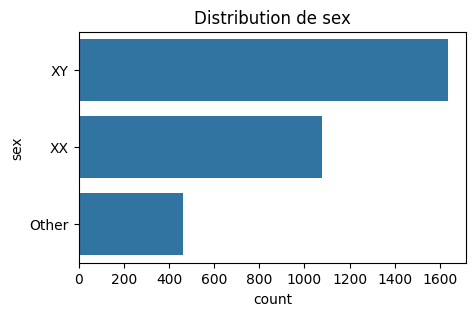


--- eln_risk ---
eln_risk
intermediate    2624
adverse          548
favorable          1
Name: count, dtype: int64


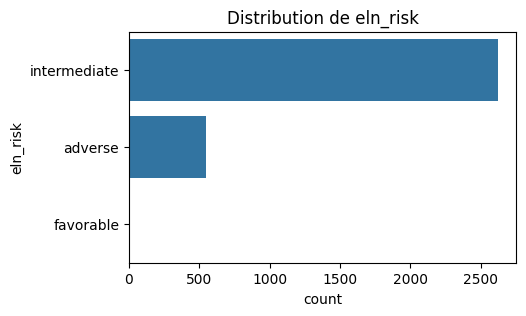


--- eln_risk_category ---
eln_risk_category
Adverse         2369
Intermediate     513
0                263
Favorable         28
Name: count, dtype: int64


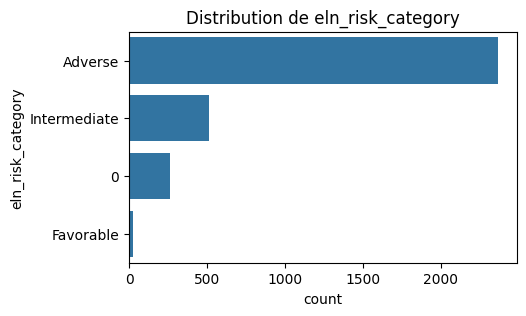

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sélection des colonnes catégorielles
cat_cols = df_train_scaled.select_dtypes(include=['object', 'category']).columns

for col in cat_cols:
    print(f"\n--- {col} ---")
    print(df_train_scaled[col].value_counts(dropna=False))
    plt.figure(figsize=(5,3))
    sns.countplot(y=col, data=df_train_scaled, order=df_train_scaled[col].value_counts().index)
    plt.title(f"Distribution de {col}")
    plt.show()

In [14]:
import numpy as np
import pandas as pd

# Sélectionne uniquement les colonnes numériques
num_df = df_train_scaled.select_dtypes(include=[np.number])

# Calcul de la matrice de corrélation
corr_matrix = num_df.corr().abs()

# On ne garde que la partie supérieure de la matrice (pour éviter les doublons)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# On trie les paires de variables par corrélation décroissante
corr_pairs = (
    upper.stack()
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={0: "correlation", "level_0": "var1", "level_1": "var2"})
)

# Affiche les 20 paires les plus corrélées
print(corr_pairs.head(20))

                         var1                      var2  correlation
0                    has_NPM1        has_NPM1_favorable     1.000000
1                    tfidf_48                  tfidf_73     1.000000
2                 is_abnormal                 is_normal     1.000000
3                     vaf_var         vaf_heterogeneity     1.000000
4                    tfidf_54                  tfidf_88     1.000000
5                    tfidf_58                  tfidf_94     1.000000
6                   has_CEBPA       has_CEBPA_favorable     1.000000
7          risk_score_genetic            risk_score_raw     1.000000
8   numerical_anomalies_count          complexity_score     0.991887
9    num_involved_chromosomes          complexity_score     0.987723
10                 depth_mean              depth_median     0.983066
11                  trisomy_8            chr_8_involved     0.979329
12                   nb_genes            nb_chromosomes     0.967903
13                   vaf_mean     

In [15]:
# Seuil de corrélation
threshold = 0.95

# Matrice de corrélation
num_df = df_train_scaled.select_dtypes(include=[np.number])
corr_matrix = num_df.corr().abs()

# Variables à supprimer
to_drop = set()
for col in corr_matrix.columns:
    # On regarde les variables déjà non supprimées
    high_corr = corr_matrix[col][corr_matrix[col] > threshold].index
    for other in high_corr:
        if other != col and other not in to_drop:
            to_drop.add(other)

# Suppression des variables très corrélées
df_train_uncorr = df_train_scaled.drop(columns=list(to_drop))
print(f"Variables supprimées (corrélation > {threshold}): {list(to_drop)}")

Variables supprimées (corrélation > 0.95): ['has_NPM1_favorable', 'tfidf_94', 'tfidf_54', 'tfidf_88', 'tfidf_73', 'has_CEBPA', 'vaf_mean', 'risk_score_raw', 'vaf_var', 'vaf_median', 'has_CEBPA_favorable', 'nb_chromosomes', 'numerical_anomalies_count', 'is_normal', 'is_abnormal', 'num_involved_chromosomes', 'depth_mean', 'complexity_score', 'tfidf_19', 'nb_genes', 'trisomy_8', 'tfidf_58', 'has_NPM1', 'vaf_heterogeneity', 'risk_score_genetic', 'depth_median', 'chr_8_involved', 'tfidf_48']


# Modèle MTLR

In [16]:
import torch
import torch.nn as nn
from torchmtlr import (MTLR, mtlr_neg_log_likelihood, mtlr_survival, mtlr_survival_at_times)
from torchmtlr.utils import encode_survival, make_time_bins
import numpy as np
import pandas as pd

X_features = df_train_scaled.drop(columns=['OS_YEARS', 'OS_STATUS'])
X_features = pd.get_dummies(X_features, drop_first=True)
X_features = X_features.astype(float)

X_features_test = pd.get_dummies(df_test_scaled, drop_first=True)
X_features_test = X_features_test.reindex(columns=X_features.columns, fill_value=0)
X_features_test = X_features_test.astype(float)

X_train = torch.tensor(X_features.values, dtype=torch.float32)
X_test = torch.tensor(X_features_test.values, dtype=torch.float32)
y_time = torch.tensor(df_train_scaled['OS_YEARS'].values, dtype=torch.float32)
y_event = torch.tensor(df_train_scaled['OS_STATUS'].values, dtype=torch.float32)

# Création des time bins
time_bins = make_time_bins(y_time, event=y_event)
target = encode_survival(y_time, y_event, time_bins)

## Hyperparameter tuning

In [ ]:
import optuna
from sklearn.model_selection import StratifiedKFold
import torch
import torch.nn as nn
import numpy as np
from sksurv.metrics import concordance_index_ipcw
from sksurv.util import Surv

def to_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return np.asarray(x)

def objective(trial):
    n_hidden1 = trial.suggest_int('n_hidden1', 16, 1024, step=16)
    n_hidden2 = trial.suggest_int('n_hidden2', 8, 512, step=8)
    n_layers = trial.suggest_int('n_layers', 2, 4)
    dropout1 = trial.suggest_float('dropout1', 0.0, 0.8)
    dropout2 = trial.suggest_float('dropout2', 0.0, 0.8)
    lr = trial.suggest_float('lr', 1e-6, 1e-2, log=True)
    n_epochs = trial.suggest_int('n_epochs', 200, 2000, step=50)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128, 256])
    activation = trial.suggest_categorical('activation', ['relu', 'leakyrelu', 'elu', 'selu'])
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'adamw', 'rmsprop', 'sgd'])
    use_weight_decay = trial.suggest_categorical('use_weight_decay', [True, False])
    if use_weight_decay:
        weight_decay = trial.suggest_float('weight_decay', 1e-7, 1e-2, log=True)
    else:
        weight_decay = 0.0
    C1 = trial.suggest_float('C1', 0.1, 20.0, log=True)

    torch.manual_seed(42)
    np.random.seed(42)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_features, df_train_scaled['OS_STATUS'])):
        X_tr, X_val = X_features.iloc[train_idx], X_features.iloc[val_idx]
        y_time_tr, y_time_val = y_time[train_idx], y_time[val_idx]
        y_event_tr, y_event_val = y_event[train_idx], y_event[val_idx]

        # Re-encode time bins pour chaque fold
        time_bins = make_time_bins(y_time_tr, event=y_event_tr)
        target_tr = encode_survival(y_time_tr, y_event_tr, time_bins)

        X_tr_torch = torch.tensor(X_tr.values, dtype=torch.float32)
        X_val_torch = torch.tensor(X_val.values, dtype=torch.float32)

        # Modèle dynamique
        layers = [nn.Linear(X_tr_torch.shape[1], n_hidden1), nn.BatchNorm1d(n_hidden1)]
        for i in range(n_layers - 1):
            if activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'leakyrelu':
                layers.append(nn.LeakyReLU())
            elif activation == 'elu':
                layers.append(nn.ELU())
            elif activation == 'selu':
                layers.append(nn.SELU())
            elif activation == 'tanh':
                layers.append(nn.Tanh())
            layers.append(nn.Dropout(dropout1 if i == 0 else dropout2))
            if i == 0:
                layers.append(nn.Linear(n_hidden1, n_hidden2))
                layers.append(nn.BatchNorm1d(n_hidden2))
            else:
                layers.append(nn.Linear(n_hidden2, n_hidden2))
                layers.append(nn.BatchNorm1d(n_hidden2))
        layers.append(MTLR(n_hidden2, len(time_bins)))
        model = nn.Sequential(*layers)

        if optimizer_name == 'adam':
            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        elif optimizer_name == 'adamw':
            optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        elif optimizer_name == 'rmsprop':
            optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)
        elif optimizer_name == 'sgd':
            optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
        else:
            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        for epoch in range(n_epochs):
            model.train()
            optimizer.zero_grad()
            logits = model(X_tr_torch)
            loss = mtlr_neg_log_likelihood(logits, target_tr, model[-1], C1=C1, average=True)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            logits_val = model(X_val_torch)
            surv_val = mtlr_survival(logits_val)
        median_pred = []
        for surv in surv_val:
            below_half = np.where(surv.numpy() <= 0.5)[0]
            if below_half.size > 0 and below_half[0] < len(time_bins):
                median_pred.append(time_bins[below_half[0]].item())
            else:
                median_pred.append(time_bins[-1].item())

        if (y_event_val == 1).sum() == 0 or (y_event_val == 0).sum() == 0:
            continue

        y_train_struct = Surv.from_arrays(event=to_numpy(y_event_tr).astype(bool), time=to_numpy(y_time_tr))
        y_val_struct = Surv.from_arrays(event=to_numpy(y_event_val).astype(bool), time=to_numpy(y_time_val))
        try:
            result = concordance_index_ipcw(
                y_train_struct,
                y_val_struct,
                -np.array(median_pred)
            )
            if isinstance(result, (tuple, list, np.ndarray)):
                cindex_ipcw = result[0]
            else:
                cindex_ipcw = result.cindex
            scores.append(cindex_ipcw)
        except Exception:
            continue

    if len(scores) == 0:
        return 0.5
    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=2000, n_jobs=4)

print("Best trial:")
print(study.best_trial)
print("Best params:", study.best_params)

In [ ]:
import optuna
from sklearn.model_selection import StratifiedKFold
import torch
import torch.nn as nn
import numpy as np
from sksurv.metrics import concordance_index_ipcw
from sksurv.util import Surv

def to_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return np.asarray(x)

def objective(trial):
    n_hidden1 = trial.suggest_int('n_hidden1', 16, 512, step=16)
    n_hidden2 = trial.suggest_int('n_hidden2', 16, 512, step=16)
    dropout1 = trial.suggest_float('dropout1', 0.0, 0.7)
    dropout2 = trial.suggest_float('dropout2', 0.0, 0.7)
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    n_epochs = trial.suggest_int('n_epochs', 100, 1000, step=50)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128, 256])
    activation = trial.suggest_categorical('activation', ['relu', 'leakyrelu', 'elu', 'selu', 'tanh'])
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'adamw', 'rmsprop', 'sgd'])
    weight_decay = trial.suggest_float('weight_decay', 1e-7, 1e-2, log=True)
    C1 = trial.suggest_float('C1', 0.1, 10.0, log=True)

    torch.manual_seed(42)
    np.random.seed(42)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_features, df_train_scaled['OS_STATUS'])):
        X_tr, X_val = X_features.iloc[train_idx], X_features.iloc[val_idx]
        y_time_tr, y_time_val = y_time[train_idx], y_time[val_idx]
        y_event_tr, y_event_val = y_event[train_idx], y_event[val_idx]

        time_bins = make_time_bins(y_time_tr, event=y_event_tr)
        target_tr = encode_survival(y_time_tr, y_event_tr, time_bins)

        X_tr_torch = torch.tensor(X_tr.values, dtype=torch.float32)
        X_val_torch = torch.tensor(X_val.values, dtype=torch.float32)

        # Activation dynamique
        if activation == 'relu':
            act_fn = nn.ReLU()
        elif activation == 'leakyrelu':
            act_fn = nn.LeakyReLU()
        elif activation == 'elu':
            act_fn = nn.ELU()
        elif activation == 'selu':
            act_fn = nn.SELU()
        elif activation == 'tanh':
            act_fn = nn.Tanh()
        else:
            act_fn = nn.ReLU()

        layers = [nn.Linear(X_tr_torch.shape[1], n_hidden1), nn.BatchNorm1d(n_hidden1), act_fn, nn.Dropout(dropout1)]
        layers += [nn.Linear(n_hidden1, n_hidden2), nn.BatchNorm1d(n_hidden2), act_fn, nn.Dropout(dropout2)]
        layers += [MTLR(n_hidden2, len(time_bins))]
        model = nn.Sequential(*layers)

        if optimizer_name == 'adamw':
            optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        elif optimizer_name == 'rmsprop':
            optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)
        elif optimizer_name == 'sgd':
            optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
        else:
            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        for epoch in range(n_epochs):
            model.train()
            optimizer.zero_grad()
            logits = model(X_tr_torch)
            loss = mtlr_neg_log_likelihood(logits, target_tr, model[-1], C1=C1, average=True)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            logits_val = model(X_val_torch)
            surv_val = mtlr_survival(logits_val)
        median_pred = []
        for surv in surv_val:
            below_half = np.where(surv.numpy() <= 0.5)[0]
            if below_half.size > 0 and below_half[0] < len(time_bins):
                median_pred.append(time_bins[below_half[0]].item())
            else:
                median_pred.append(time_bins[-1].item())

        if (y_event_val == 1).sum() == 0 or (y_event_val == 0).sum() == 0:
            continue

        y_train_struct = Surv.from_arrays(event=to_numpy(y_event_tr).astype(bool), time=to_numpy(y_time_tr))
        y_val_struct = Surv.from_arrays(event=to_numpy(y_event_val).astype(bool), time=to_numpy(y_time_val))
        try:
            result = concordance_index_ipcw(
                y_train_struct,
                y_val_struct,
                -np.array(median_pred)
            )
            cindex_ipcw = result[0] if isinstance(result, (tuple, list, np.ndarray)) else result.cindex
            scores.append(cindex_ipcw)
        except Exception:
            continue

    if len(scores) == 0:
        return 0.5
    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=2000, n_jobs=3)

print("Best trial:")
print(study.best_trial)
print("Best params:", study.best_params)

[I 2025-07-29 20:32:18,237] A new study created in memory with name: no-name-c77c174f-bffe-4f5b-b697-ac26cfd377d6
[I 2025-07-29 20:33:41,696] Trial 2 finished with value: 0.5589970074907237 and parameters: {'n_hidden1': 192, 'n_hidden2': 128, 'dropout1': 0.0007868302755647871, 'dropout2': 0.4463039000670195, 'lr': 1.0648123652958785e-05, 'n_epochs': 250, 'batch_size': 64, 'activation': 'elu', 'optimizer': 'sgd', 'weight_decay': 0.000476344605798153, 'C1': 8.087226915615933}. Best is trial 2 with value: 0.5589970074907237.
[I 2025-07-29 20:34:06,900] Trial 1 finished with value: 0.6591789083685422 and parameters: {'n_hidden1': 416, 'n_hidden2': 32, 'dropout1': 0.052949112998216606, 'dropout2': 0.03269806409307929, 'lr': 0.0003916512862433678, 'n_epochs': 300, 'batch_size': 256, 'activation': 'relu', 'optimizer': 'adam', 'weight_decay': 9.484021086970444e-05, 'C1': 0.18693859103005864}. Best is trial 1 with value: 0.6591789083685422.
[I 2025-07-29 20:34:13,054] Trial 0 finished with valu

In [ ]:
import json

with open("best_params.txt", "w") as f:
    f.write(json.dumps(study.best_params, indent=4))

In [17]:
best_params= {'n_hidden1': 288, 'n_hidden2': 144, 'dropout1': 0.6848490747149155, 'dropout2': 0.14044022390731736, 'lr': 0.00023744819326198277, 'n_epochs': 100, 'batch_size': 32, 'activation': 'relu', 'optimizer': 'rmsprop', 'weight_decay': 0.004512149487379765, 'C1': 0.8228498002948286}

In [18]:
# Training avec les meilleurs paramètres Optuna (optimizer AdamW, pas de weight decay)
import torch
import torch.nn as nn

n_hidden1 = best_params['n_hidden1']
n_hidden2 = best_params['n_hidden2']
dropout1 = best_params['dropout1']
dropout2 = best_params['dropout2']
lr = best_params['lr']
activation = 'relu'  # Fixé
weight_decay = 0.0  # Pas de weight decay
n_epochs = best_params['n_epochs']
C1 = best_params['C1']

# Sélection dynamique de l'activation
if activation == 'relu':
    act_fn = nn.ReLU()
elif activation == 'leakyrelu':
    act_fn = nn.LeakyReLU()
elif activation == 'elu':
    act_fn = nn.ELU()
elif activation == 'selu':
    act_fn = nn.SELU()
elif activation == 'tanh':
    act_fn = nn.Tanh()
else:
    raise ValueError(f"Activation inconnue: {activation}")

model = nn.Sequential(
    nn.Linear(X_train.shape[1], n_hidden1),
    nn.BatchNorm1d(n_hidden1),
    act_fn,
    nn.Dropout(dropout1),
    nn.Linear(n_hidden1, n_hidden2),
    nn.BatchNorm1d(n_hidden2),
    act_fn,
    nn.Dropout(dropout2),
    MTLR(n_hidden2, len(time_bins))
)

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

# Entraînement
for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    logits = model(X_train)
    loss = mtlr_neg_log_likelihood(logits, target, model[-1], C1=C1, average=True)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{n_epochs} - Loss: {loss.item():.4f}")

# Prédiction train
model.eval()
with torch.no_grad():
    logits_train = model(X_train)
    surv_train = mtlr_survival(logits_train)

median_pred = []
for surv in surv_train:
    below_half = np.where(surv.numpy() <= 0.5)[0]
    if below_half.size > 0 and below_half[0] < len(time_bins):
        median_pred.append(time_bins[below_half[0]].item())
    else:
        median_pred.append(time_bins[-1].item())

# Évaluation
from sksurv.util import Surv
from sksurv.metrics import concordance_index_ipcw

y_train_struct = Surv.from_arrays(event=df_train_scaled['OS_STATUS'].values.astype(bool),
                                  time=df_train_scaled['OS_YEARS'].values)
score_ipwc = concordance_index_ipcw(y_train_struct, y_train_struct, -np.array(median_pred))[0]
print(f"Concordance index IPCW (train): {score_ipwc:.3f}")

Epoch 10/100 - Loss: 27.7792
Epoch 20/100 - Loss: 26.7682
Epoch 30/100 - Loss: 25.8992
Epoch 40/100 - Loss: 25.0690
Epoch 50/100 - Loss: 24.2434
Epoch 60/100 - Loss: 23.3965
Epoch 70/100 - Loss: 22.6430
Epoch 80/100 - Loss: 21.8931
Epoch 90/100 - Loss: 21.1995
Epoch 100/100 - Loss: 20.5342
Concordance index IPCW (train): 0.714


## Training

In [32]:

# Utilisation des meilleurs paramètres trouvés par Optuna
n_hidden1 = best_params['n_hidden1']
n_hidden2 = best_params['n_hidden2']
dropout1 = best_params['dropout1']
dropout2 = best_params['dropout2']
lr = best_params['lr']
activation = best_params['activation']
weight_decay = best_params['use_weight_decay']
n_epochs = best_params['n_epochs']

# Sélection dynamique de l'activation
if activation == 'relu':
    act_fn = nn.ReLU()
elif activation == 'leakyrelu':
    act_fn = nn.LeakyReLU()
elif activation == 'elu':
    act_fn = nn.ELU()
elif activation == 'selu':
    act_fn = nn.SELU()
elif activation == 'tanh':
else:
    raise ValueError(f"Activation inconnue: {activation}")

model = nn.Sequential(
    nn.Linear(X_train.shape[1], n_hidden1),
    nn.BatchNorm1d(n_hidden1),
    act_fn,
    nn.Dropout(dropout1),
    nn.Linear(n_hidden1, n_hidden2),
    nn.BatchNorm1d(n_hidden2),
    act_fn,
    nn.Dropout(dropout2),
    MTLR(n_hidden2, len(time_bins))
)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

# Entraînement
for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    logits = model(X_train)
    loss = mtlr_neg_log_likelihood(logits, target, model[-1], C1=1., average=True)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{n_epochs} - Loss: {loss.item():.4f}")

# Prédiction train
model.eval()
with torch.no_grad():
    logits_train = model(X_train)
    surv_train = mtlr_survival(logits_train)

median_pred = []
for surv in surv_train:
    below_half = np.where(surv.numpy() <= 0.5)[0]
    if below_half.size > 0 and below_half[0] < len(time_bins):
        median_pred.append(time_bins[below_half[0]].item())
    else:
        median_pred.append(time_bins[-1].item())

# Évaluation
from sksurv.util import Surv
from sksurv.metrics import concordance_index_ipcw

y_train_struct = Surv.from_arrays(event=df_train_scaled['OS_STATUS'].values.astype(bool),
                                  time=df_train_scaled['OS_YEARS'].values)
score_ipwc = concordance_index_ipcw(y_train_struct, y_train_struct, -np.array(median_pred))[0]
print(f"Concordance index IPCW (train): {score_ipwc:.3f}")


TypeError: '<=' not supported between instances of 'float' and 'str'

## Inference

In [19]:
# Prépare les features test (déjà fait dans ton code)
X_test_torch = torch.tensor(X_features_test.values, dtype=torch.float32)

# Prédiction
model.eval()
with torch.no_grad():
    logits_test = model(X_test_torch)
    surv_test = mtlr_survival(logits_test)
    median_pred_test = []
    for surv in surv_test:
        below_half = np.where(surv.numpy() <= 0.5)[0]
        if below_half.size > 0 and below_half[0] < len(time_bins):
            median_pred_test.append(time_bins[below_half[0]].item())
        else:
            median_pred_test.append(time_bins[-1].item())

# Soumission
risk_score_test = -np.array(median_pred_test)
submission = pd.DataFrame({
    "ID": ID_test.values,
    "risk_score": risk_score_test
})
submission.to_csv("submission_mtlr.csv", index=False)

## SHAP Feature importance

In [23]:
min_risk = submission['risk_score'].min()
max_risk = submission['risk_score'].max()
print("Minimum risk :", min_risk)
print("Maximum risk :", max_risk)

Minimum risk : -7.443835735321045
Maximum risk : -0.20821918547153473


Temps cible 12 → intervalle index 8 (≈ 12.0)


  0%|          | 0/20 [00:00<?, ?it/s]

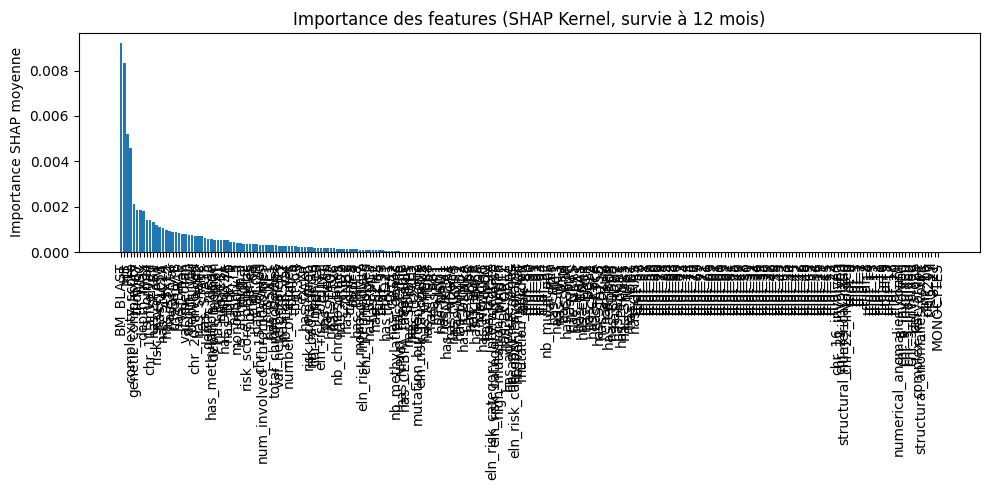

In [24]:
import torch
import shap
import numpy as np
import matplotlib.pyplot as plt

# ⚙️ Paramètres
T_max = 60
n_intervals = 41
t_target = 12

time_grid = np.linspace(0, T_max, n_intervals)
time_idx = np.argmin(np.abs(time_grid - t_target))

print(f"Temps cible {t_target} → intervalle index {time_idx} (≈ {time_grid[time_idx]:.1f})")

background_np = X_features.iloc[:100].values
test_sample_np = X_features.iloc[100:120].values
features = np.array(X_features.columns)

model.eval()

# Fonction prédictive pour SHAP : proba de survie à t_target
def predict_fn(x_numpy):
    x_torch = torch.tensor(x_numpy, dtype=torch.float32)
    with torch.no_grad():
        logits = model(x_torch)  # (batch_size, n_intervals)
        surv = mtlr_survival(logits)  # (batch_size, n_intervals), valeurs entre 0 et 1
        y_target = surv[:, time_idx].numpy()  # proba de survie à t_target
    return y_target

explainer = shap.KernelExplainer(predict_fn, background_np)

# Valeurs SHAP
shap_values = explainer.shap_values(test_sample_np, nsamples=100)

feature_importance = np.mean(np.abs(shap_values), axis=0)
sorted_idx = np.argsort(feature_importance)[::-1]

plt.figure(figsize=(10, 5))
plt.bar(features[sorted_idx], feature_importance[sorted_idx])
plt.xticks(rotation=90)
plt.title(f"Importance des features (SHAP Kernel, survie à {t_target} mois)")
plt.ylabel("Importance SHAP moyenne")
plt.tight_layout()
plt.show()

In [25]:
import pandas as pd

# Création du tableau d'importance trié
shap_df = pd.DataFrame({
    "feature": features[sorted_idx],
    "importance": feature_importance[sorted_idx]
}).reset_index(drop=True)

# Affichage markdown pour LLM
print("\nTableau markdown pour LLM :\n")
print(shap_df.to_markdown(index=False))


Tableau markdown pour LLM :

| feature                        |   importance |
|:-------------------------------|-------------:|
| BM_BLAST                       |  0.00920469  |
| HB                             |  0.0083339   |
| PLT                            |  0.00521865  |
| complexity_score               |  0.00458192  |
| genetic_complexity             |  0.00213011  |
| tfidf_67                       |  0.00186794  |
| WBC                            |  0.00186487  |
| depth_max                      |  0.00178917  |
| is_normal                      |  0.00140275  |
| chr_11_involved                |  0.00140031  |
| has_SF3B1                      |  0.00132728  |
| risk_score_raw                 |  0.00119719  |
| has_TP53                       |  0.00112187  |
| has_SMC1A                      |  0.00107861  |
| has_ASXL2                      |  0.000979784 |
| has_TET2                       |  0.000928693 |
| vaf_var                        |  0.00089599  |
| trisomy_8         